<a href="https://colab.research.google.com/github/1zuu/Machine-Learning-With-Graphs/blob/main/7_GNN_Tasks_Molecule_Graph_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
# Install rdkit
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO
 
 
logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)
 
 
def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """
 
    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )
 
    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)
 
    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return
 
        logger.info("force re-install")
 
    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)
 
    logger.info("python version: {}".format(python_version))
 
    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)
 
    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')
 
    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')
 
    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python==3.7.3",
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")
 
    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))
 
 
if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.13
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.09.1 installation finished!


In [2]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 7.9 MB 53.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 3.5 MB 27.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 2.4 MB 24.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 709 kB 19.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     

In [21]:
import warnings
warnings.filterwarnings("ignore")

import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

import torch, os
import torch_geometric
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from itertools import combinations
from matplotlib import pyplot as plt

In [4]:
working_dir = '/content/drive/My Drive/Colab Notebooks/machine-learning-with-graphs/'
collection = 'MoleculeNet'
dataset = 'ESOL'

data_dir = os.path.join(working_dir, collection)

In [5]:
data = MoleculeNet(root=data_dir, name=dataset)

print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)


data0 = data[0]  # Get the first graph object.
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data0.num_nodes}')
print(f'Number of edges: {data0.num_edges}')
print(f'Average node degree: {data0.num_edges / data0.num_nodes:.2f}')
print(f'Has isolated nodes: {data0.has_isolated_nodes()}')
print(f'Has self-loops: {data0.has_self_loops()}')
print(f'Is undirected: {data0.is_undirected()}')

Processing...


Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  734
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], y=[1, 1], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ')
Sample  nodes:  32
Sample  edges:  68
Number of nodes: 32
Number of edges: 68
Average node degree: 2.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


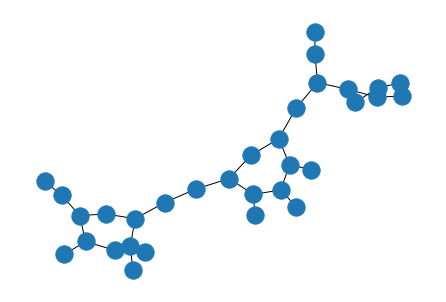

In [6]:
graph0 = to_networkx(data0, to_undirected=True)
nx.draw(graph0)

In [7]:

smile0 = data0["smiles"]
smile0

'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '

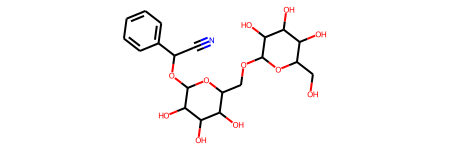

In [8]:
molecule0 = Chem.MolFromSmiles(smile0)
molecule0

In [9]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_dim = 64):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers (Message Passing Layers)
        self.initial_conv = GCNConv(data.num_features, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)

        # Output layer
        self.out = Linear(hidden_dim*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
          
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

In [10]:
model = GCN()
model

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)

In [26]:
class MoleculeClassification(object):
    def __init__(self):
        self.loss_fn = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(
                                    model.parameters(), 
                                    lr = 0.0007
                                    )  

        # Use GPU for training
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.TorchDataLoader()

    def TorchDataLoader(self, batch_size = 64, train_split = 0.8):
        data_size = len(data)
        self.loader = DataLoader(
                            data[:int(data_size * train_split)], 
                            batch_size=batch_size, 
                            shuffle=True
                            )

        self.test_loader = DataLoader(
                            data[int(data_size * (1 - train_split)):], 
                            batch_size=batch_size, 
                            shuffle=True
                            )

    def train_epoch(self):
        self.model.train()
        for batch in self.loader:
            batch.to(self.device)  
            self.optimizer.zero_grad() 
            pred, embedding = self.model(batch.x.float(), batch.edge_index, batch.batch) 
            loss = self.loss_fn(pred, batch.y)     
            loss.backward()  
            self.optimizer.step()   
        return loss, embedding

    def train(self, epoches = 2000):
        print("Starting training...")
        losses = []
        for epoch in range(epoches):
            loss, h = self.train_epoch()
            loss = loss.item()
            losses.append(loss)
            if epoch % 100 == 0:
              print(f"Epoch {epoch} | Train Loss {loss}")
        self.plot_loss(losses)

    def plot_loss(self, losses):
        losses_float = [loss for loss in losses] 
        loss_indices = [i for i,l in enumerate(losses_float)] 
        plt = sns.lineplot(loss_indices, losses_float)

    def predictions(self):
        # Analyze the results for one batch
        test_batch = next(iter(self.test_loader))
        with torch.no_grad():
            test_batch.to(self.device)
            pred, embed = self.model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
            df = pd.DataFrame()
            df["y_real"] = test_batch.y.tolist()
            df["y_pred"] = pred.tolist()
        df["y_real"] = df["y_real"].apply(lambda row: row[0])
        df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
        return df

Starting training...
Epoch 0 | Train Loss 0.06973153352737427
Epoch 100 | Train Loss 0.03854382410645485
Epoch 200 | Train Loss 0.018828194588422775
Epoch 300 | Train Loss 0.01827569305896759
Epoch 400 | Train Loss 0.027785075828433037
Epoch 500 | Train Loss 0.043412283062934875
Epoch 600 | Train Loss 0.007206962443888187
Epoch 700 | Train Loss 0.029433151707053185
Epoch 800 | Train Loss 0.003191084135323763
Epoch 900 | Train Loss 0.006492955144494772
Epoch 1000 | Train Loss 0.05812981724739075
Epoch 1100 | Train Loss 0.004109516739845276
Epoch 1200 | Train Loss 0.009729038923978806
Epoch 1300 | Train Loss 0.042498718947172165
Epoch 1400 | Train Loss 0.008646389469504356
Epoch 1500 | Train Loss 0.00800818856805563
Epoch 1600 | Train Loss 0.008141223341226578
Epoch 1700 | Train Loss 0.009793758392333984
Epoch 1800 | Train Loss 0.015322326682507992
Epoch 1900 | Train Loss 0.013310400769114494


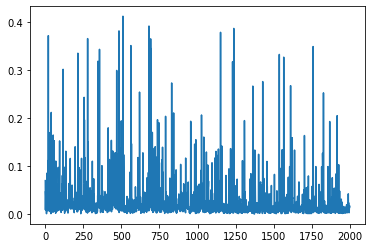

In [29]:
classifier = MoleculeClassification()
classifier.train()

In [30]:
df_batch = classifier.predictions()
df_batch

,y_real,y_pred
0,-5.060,-5.141331
1,-2.360,-2.214884
2,-2.943,-1.420631
3,-1.290,-1.230772
4,-0.920,0.072759
...,...,...
59,-4.883,-4.392336
60,-2.596,-2.449353
61,-2.863,-3.356582
62,-3.760,-4.727808


[(-7.0, 2.0)]

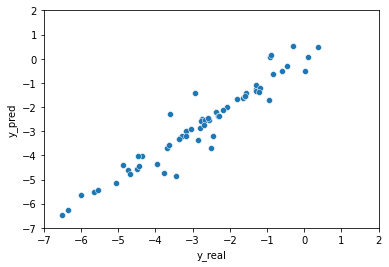

In [31]:
plt = sns.scatterplot(data=df_batch, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))

# Why Global Graph Pooling ??
  
Graphs Have Different Sizes (Different Number of Nodes & Edges). Since we doing  **Graph Level** Prediction we need perform this representative learning networks for dynamic sizes of graphs with fixed size output. So we use **Global Pooling Mechanism** to squeeze any number of nodes (differnet sizes) into one fixed representation. Here we use MEAN & MAX global pooling techniques in that case

